In [46]:
import os
import warnings
import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# for padding a list of variable length tensors to equal length
from torch.nn.utils.rnn import pad_sequence
# for packing a tensor containing padded sequences of variable length
from torch.nn.utils.rnn import pack_padded_sequence

import nltk
# for removing stop words like 'the', 'and', etc
# stop words don't provide useful information
from nltk.corpus import stopwords
# for tokenization
from nltk.tokenize import word_tokenize

# for counting the number of unique tokens
from collections import Counter


In [48]:
# suppress all warnings
warnings.filterwarnings("ignore")

# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [50]:
# Load the concatenated_MV file as a pandas DataFrame
file_path = 'concatenated_MV.xlsx'  # Update this path to the actual file location
df_loreal = pd.read_excel(file_path)


# Display the first few rows of the DataFrame
print(df_loreal.head())

                                         description  dark_pigmentation  acne  \
0  Australian Gold Deviously Black 45X Dark Bronz...                  0     0   
1  Australian Gold Sunscreen  Spray Gel with Inst...                  0     0   
2  Australian Gold Sunscreen Spray Gel - SPF 15 -...                  0     0   
3  Avalon Organics Intense Defense Oil-Free Moist...                  0     0   
4  Avalon Organics Vitamin C Renewal Facial Cream...                  0     0   

   eye_contour  homogeneity  lack_firmness  lack_radiance  pores  fine_lines  \
0            0            0              0              0      0           0   
1            0            0              0              1      0           0   
2            0            0              0              0      0           0   
3            0            0              0              0      0           0   
4            0            1              0              1      0           0   

   wrinkles_fine-lines  ...  fem

In [51]:
# Extract the output class names (column names excluding the text column)
output_classes = list(df_loreal.columns[1:34])  # Exclude the 'text_raw' column

num_classes = len(output_classes)

# Display the output
print(f"Number of output classes: {num_classes}")
print("List of output classes:")
print(output_classes)

Number of output classes: 33
List of output classes:
['dark_pigmentation', 'acne', 'eye_contour', 'homogeneity', 'lack_firmness', 'lack_radiance', 'pores', 'fine_lines', 'wrinkles_fine-lines', 'eye-wrinkles', 'undereye-bags', 'generic', '18-34', '35-54', '55-99', 'dry', 'normal', 'oily', 'combination', 'sensitivity-high', 'sensitivity-low', 'no_sensitivity', 'male', 'female', 'cleanse', 'prepare', 'treat', 'targeted', 'care', 'moisturize', 'protect', 'day', 'night']


In [52]:
# ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# set the stop words to the English mode
stop_words = set(stopwords.words('english'))

# define a function for pre-processing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # remove stop words
    return tokens

# Apply preprocessing to the 'text_raw' column
df_loreal["tokens"] = df_loreal["description"].apply(preprocess_text)

# Display first few tokenized samples
df_loreal[["description", "tokens"]].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coope\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\coope\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\coope\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,description,tokens
0,Australian Gold Deviously Black 45X Dark Bronz...,"[australian, gold, deviously, black, 45x, dark..."
1,Australian Gold Sunscreen Spray Gel with Inst...,"[australian, gold, sunscreen, spray, gel, inst..."
2,Australian Gold Sunscreen Spray Gel - SPF 15 -...,"[australian, gold, sunscreen, spray, gel, -, s..."
3,Avalon Organics Intense Defense Oil-Free Moist...,"[avalon, organics, intense, defense, oil-free,..."
4,Avalon Organics Vitamin C Renewal Facial Cream...,"[avalon, organics, vitamin, c, renewal, facial..."


In [53]:
# build vocabulary
all_tokens = [token for tokens in df_loreal['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print('The number of unique tokens in the vocabulary:', len(token_counts))

The number of unique tokens in the vocabulary: 24064


Fitted Normal Distribution: mu = 25.94, sigma = 392.86


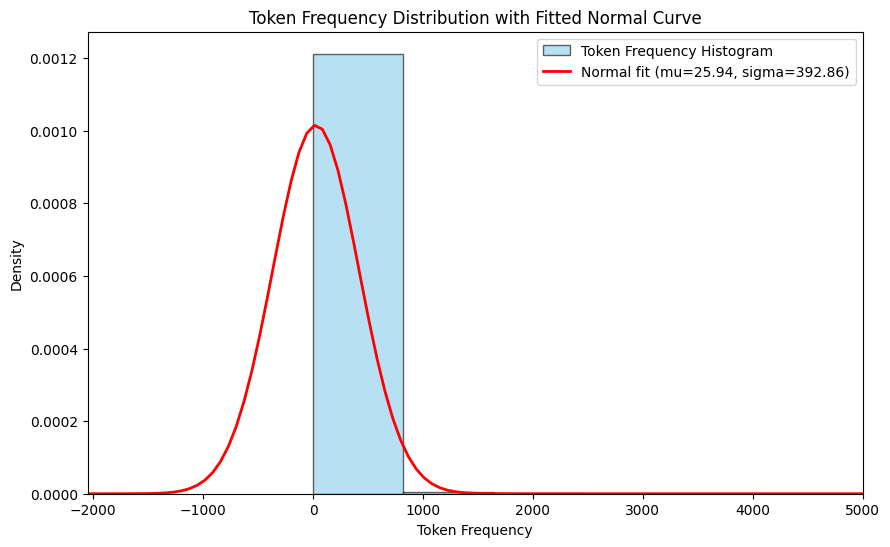

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assume token_counts is already defined from our vocabulary creation step:
# token_counts = Counter(all_tokens)

# Get an array of token frequencies
frequencies = np.array(list(token_counts.values()))

# Plot the histogram of token frequencies
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(frequencies, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Token Frequency Histogram')

# Fit a normal distribution to the frequency data
mu, sigma = norm.fit(frequencies)
print(f"Fitted Normal Distribution: mu = {mu:.2f}, sigma = {sigma:.2f}")

# Set the x-axis maximum to 10,000
xmin, _ = plt.xlim()
xmax = 5000
plt.xlim(xmin, xmax)

# Create a range of values for plotting the PDF of the fitted normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)

# Plot the fitted normal distribution curve
plt.plot(x, p, 'r', linewidth=2, label=f'Normal fit (mu={mu:.2f}, sigma={sigma:.2f})')
plt.xlabel('Token Frequency')
plt.ylabel('Density')
plt.title('Token Frequency Distribution with Fitted Normal Curve')
plt.legend()
plt.show()



In [55]:
# Set vocabulary size (excluding special tokens)
vocab_size = 24000  # Adjust as needed

# Keep only the most common words (excluding special tokens)
common_tokens = token_counts.most_common(vocab_size - 2)  # Reserve space for <PAD> and <UNK>

# Create token-to-index mappings
token_to_idx = {token: idx + 2 for idx, (token, _) in enumerate(common_tokens)}

# Special tokens
token_to_idx["<PAD>"] = 0  # Padding token
token_to_idx["<UNK>"] = 1  # Unknown token

# Create index-to-token mapping (for decoding)
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

# Define a function to encode tokens into integer sequences
def encode_tokens(tokens):
    return [token_to_idx.get(token, token_to_idx["<UNK>"]) for token in tokens]

# Apply encoding to the dataset
df_loreal["encoded_tokens"] = df_loreal["tokens"].apply(encode_tokens)

# Display first few rows with encoded tokens
df_loreal[["description", "tokens", "encoded_tokens"]].head()

,description,tokens,encoded_tokens
0,Australian Gold Deviously Black 45X Dark Bronz...,"[australian, gold, deviously, black, 45x, dark...","[1002, 390, 9460, 384, 12863, 54, 1687, 4400, ..."
1,Australian Gold Sunscreen Spray Gel with Inst...,"[australian, gold, sunscreen, spray, gel, inst...","[1002, 390, 29, 173, 61, 270, 1687, 9, 26, 213..."
2,Australian Gold Sunscreen Spray Gel - SPF 15 -...,"[australian, gold, sunscreen, spray, gel, -, s...","[1002, 390, 29, 173, 61, 9, 26, 126, 9, 392, 8..."
3,Avalon Organics Intense Defense Oil-Free Moist...,"[avalon, organics, intense, defense, oil-free,...","[3066, 1539, 397, 541, 156, 20, 2, 100, 17, 30..."
4,Avalon Organics Vitamin C Renewal Facial Cream...,"[avalon, organics, vitamin, c, renewal, facial...","[3066, 1539, 24, 53, 367, 31, 7, 2, 3432, 3066..."


In [57]:
# Define a custom Dataset class
class LOREALMultiLabelDataset(Dataset):
    def __init__(self, encoded_tokens_list, labels):
        self.encoded_tokens_list = encoded_tokens_list
        self.labels = labels

    def __len__(self):
        return len(self.encoded_tokens_list)

    def __getitem__(self, idx):
        X = self.encoded_tokens_list[idx]
        y = self.labels[idx]
        
        # Convert to PyTorch tensors
        X = torch.tensor(X, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.float)  # Multi-label classification requires float

        return X, y

# Define a collate function to handle variable sequence lengths
def collate_batch(batch):
    batch_X, batch_y, batch_length = [], [], []

    for (X, y) in batch:
        batch_X.append(X)
        batch_y.append(y)
        batch_length.append(len(X))

    # Convert batch_length to tensor
    batch_length = torch.tensor(batch_length, dtype=torch.int64)
    batch_y = torch.stack(batch_y)  # Stack labels into a tensor

    # Pad sequences to equal length
    batch_X = pad_sequence(batch_X, batch_first=True)

    return batch_X, batch_y, batch_length

In [ ]:

# Create a single dataset instance from your encoded tokens and multi-label targets
ds = LOREALMultiLabelDataset(
    df_loreal["encoded_tokens"].tolist(), 
    df_loreal.iloc[:, 1:34].values  # columns 2 to 33 for labels
)
train_val_ds, test_ds = random_split(ds, [0.7, 0.3])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])

In [59]:
# Define batch size
batch_size = 64

# Create DataLoader instances
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Display dataset statistics
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 3495
Validation dataset size: 873
Test dataset size: 1872


In [60]:
import torch.nn as nn

# Define the Multi-Label LSTM Model
class MultiLabelLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)  # Output size = number of labels
        
    def forward(self, x, lengths):
        # Convert token IDs into embeddings
        x = self.embedding(x)

        # Pack padded sequences for efficient LSTM processing
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        out, (h, c) = self.lstm(packed_x)
        
        # Fully connected layer with sigmoid activation (multi-label)
        return torch.sigmoid(self.fc(h[-1]))  # Sigmoid for independent label probabilities


In [61]:
print(num_classes)

33


In [62]:
# Define model parameters
embed_size = 128
hidden_size = 64

# Create the model instance
model = MultiLabelLSTM(vocab_size, embed_size, hidden_size, num_classes)

# Move model to computation device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model architecture
print(model)

MultiLabelLSTM(
  (embedding): Embedding(24000, 128)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=33, bias=True)
)


In [63]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()

    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y, lens in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            logits = model(X, lens)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y, lens in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y, lens = X.to(device), y.to(device), lens.to(device)
                logits = model(X, lens)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')

        # early stopping
        if val_epoch_loss < min_val_loss:
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'epoch{epoch+1}val_loss{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
            patience_counter += 1
            if (val_epoch_loss + 0.009) < min_val_loss:
                patience_counter = 0
                print('Reset patience counter\n')            
            min_val_loss = val_epoch_loss
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [64]:
# define the training hyper-parameters
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 10000000
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)
saved_path_prefix = 'loreal_product_classifier'

In [65]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s]


Epoch 1: train loss = 0.757924, val loss = 0.756433, time consumed = 0:01:22
Model saved after epoch 1
Reset patience counter



Training batch	:   5%|▌         | 3/55 [00:06<01:45,  2.03s/it]


KeyboardInterrupt: 

In [ ]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# reload the best model
model.load_state_dict(torch.load(saved_path))
model.to(device)

In [ ]:
def test_model(test_dl, model, loss_fn, threshold=0.5):
    test_loss = 0.0
    all_logits = []
    all_probs = []
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for X_batch, y_batch, lengths in test_dl:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            
            # Forward pass: get predicted probabilities
            logits = model(X_batch, lengths)  # Shape: (batch_size, num_classes)
            
            # Calculate loss for this batch
            loss = loss_fn(logits, y_batch)
            test_loss += loss.item()
            
            # Get predicted probabilities (our model already applies sigmoid)
            probs = logits  
            
            # Convert probabilities to binary predictions using threshold
            preds = (probs >= threshold).float()
            
            # Collect outputs and ground truth for evaluation
            all_logits.append(logits.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())
    
    # Average test loss over batches
    test_loss /= len(test_dl)
    
    # Concatenate outputs from all batches
    all_true = np.concatenate(all_true, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    print(f"Test Loss: {test_loss:.4f}")
    return all_logits, all_probs, all_preds, all_true

In [ ]:
# Evaluate the model on the test set using the test_model function
all_logits, all_probs, all_preds, all_true = test_model(test_dl, model, loss_fn, threshold=0.5)

# Create a list of output class names from the dataframe (excluding 'text_raw')
output_classes = list(df_loreal.columns[1:34])  # Adjust if needed

# Print classification metrics for each label
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=output_classes))